# Ice - Albedo Feedback and runaway glaciation

Here we will use the 1-dimensional diffusive Energy Balance Model (EBM) to explore the effects of albedo feedback and heat transport on climate sensitivity.

In [1]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const
from climlab import legendre

## Annual-mean model with albedo feedback: adjustment to equilibrium

A version of the EBM in which albedo adjusts to the current position of the ice line, wherever $T < T_f$

In [2]:
model1 = climlab.EBM_annual( num_points = 180, a0=0.3, a2=0.078, ai=0.62)
print(model1)

climlab Process of type <class 'climlab.model.ebm.EBM_annual'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.ebm.EBM_annual'>
   LW: <class 'climlab.radiation.aplusbt.AplusBT'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   albedo: <class 'climlab.surface.albedo.StepFunctionAlbedo'>
      iceline: <class 'climlab.surface.albedo.Iceline'>
      warm_albedo: <class 'climlab.surface.albedo.P2Albedo'>
      cold_albedo: <class 'climlab.surface.albedo.ConstantAlbedo'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>



In [3]:
model1.integrate_years(5)
Tequil = np.array(model1.Ts)
ALBequil = np.array(model1.albedo)
OLRequil = np.array(model1.OLR)
ASRequil = np.array(model1.ASR)

Integrating for 450 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 5.000000000000044 years.


Let's look at what happens if we perturb the temperature -- make it 20ºC colder everywhere!

In [4]:
model1.Ts -= 20.
model1.compute_diagnostics()

Let's take a look at how we have just perturbed the absorbed shortwave:

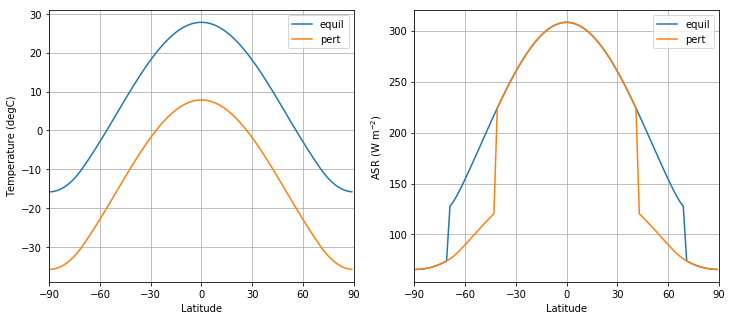

In [5]:
my_ticks = [-90,-60,-30,0,30,60,90]
lat = model1.lat

fig = plt.figure( figsize=(12,5) )

ax1 = fig.add_subplot(1,2,1)
ax1.plot(lat, Tequil, label='equil') 
ax1.plot(lat, model1.Ts, label='pert' )
ax1.grid()
ax1.legend()
ax1.set_xlim(-90,90)
ax1.set_xticks(my_ticks)
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Temperature (degC)')

ax2 = fig.add_subplot(1,2,2)
ax2.plot( lat, ASRequil, label='equil') 
ax2.plot( lat, model1.ASR, label='pert' )
ax2.grid()
ax2.legend()
ax2.set_xlim(-90,90)
ax2.set_xticks(my_ticks)
ax2.set_xlabel('Latitude')
ax2.set_ylabel('ASR (W m$^{-2}$)')

plt.show()

So there is less absorbed shortwave now, because of the increased albedo. The global mean difference is:

In [6]:
climlab.global_mean( model1.ASR - ASRequil )

Field(-20.37046205447195)

Less shortwave means that there is a tendency for the climate to cool down even more! In other words, the shortwave feedback is **positive**.

Recall that the net feedback for the EBM can be written

$\lambda = - B + \frac{\Delta <(1-\alpha) Q >}{\Delta <T>}$

where the second term is the change in the absorbed shortwave per degree global mean temperature change.

Plugging these numbers in gives

$\lambda = - 2 + \frac{-20.4}{-20} = -2 + 1 = -1$ W m$^{-2}$ $^{\circ}$C$^{-1}$

The feedback is negative, as we expect! The tendency to warm up from reduced OLR outweighs the tendency to cool down from reduced ASR. A negative net feedback means that the system will relax back towards the equilibrium.

Let's let the temperature evolve one year at a time and add extra lines to the graph:

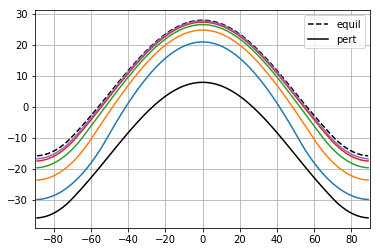

In [7]:
plt.plot( lat, Tequil, 'k--', label='equil' )
plt.plot( lat, model1.Ts, 'k-', label='pert' )
plt.grid()
plt.xlim(-90,90)
plt.legend()

for n in range(5):
    model1.integrate_years(years=1.0, verbose=False)
    plt.plot(lat, model1.Ts)

Temperature drifts back towards equilibrium, as we expected!

What if we cool the climate **so much** that the entire planet is ice covered?

In [8]:
model1.Ts -= 40.
model1.compute_diagnostics()

Look again at the change in absorbed shortwave:

In [9]:
climlab.global_mean( model1.ASR - ASRequil )

Field(-108.99200830729608)

It's much larger because we've covered so much more surface area with ice!

The feedback calculation now looks like

$\lambda = - 2 + \frac{-109}{-40} = -2 + 2.7 = +0.7$ W m$^{-2}$ $^{\circ}$C$^{-1}$

What? Looks like the **positive** albedo feedback is so strong here that it has outweighed the **negative** longwave feedback. What will happen to the system now? Let's find out...

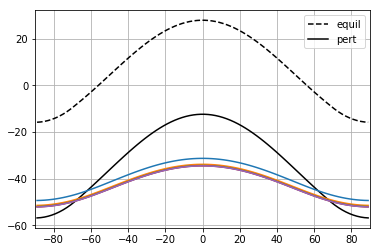

In [10]:
plt.plot( lat, Tequil, 'k--', label='equil' )
plt.plot( lat, model1.Ts, 'k-', label='pert' )
plt.grid()
plt.xlim(-90,90)
plt.legend()

for n in range(5):
    model1.integrate_years(years=1.0, verbose=False)
    plt.plot(lat, model1.Ts)

Something **very different** happened! The climate drifted towards an entirely different equilibrium state, in which the entire planet is cold and ice-covered.

We will refer to this as the **SNOWBALL EARTH**.

Note that the warmest spot on the planet is still the equator, but it is now about -33ºC rather than +28ºC!

## Here Comes the Sun! Where is the ice edge?

The ice edge in our model is always where the temperature crosses $T_f = -10^\circ$C. The system is at **equilibrium** when the temperature is such that there is a balance between ASR, OLR, and heat transport convergence everywhere. 

Suppose that sun was hotter or cooler at different times (in fact it was significantly cooler during early Earth history). That would mean that the solar constant $S_0 = 4Q$ was larger or smaller. We should expect that the temperature (and thus the ice edge) should increase and decrease as we change $S_0$. 

$S_0$ during the Neoproterozoic Snowball Earth events is believed to be about 93% of its present-day value, or about 1270 W m$^{-2}$.

We are going to look at how the **equilibrium** ice edge depends on $S_0$, by integrating the model out to equilibrium for lots of different values of $S_0$. We will start by slowly decreasing $S_0$, and then slowly increasing $S_0$.

In [11]:
model2 = climlab.EBM_annual(num_points = 360, a0=0.3, a2=0.078, ai=0.62)

In [12]:
S0array = np.linspace(1400., 1200., 200.)
#S0array = np.linspace(1400., 1200., 10.)
#print S0array

/Users/br546577/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [13]:
model2.integrate_years(5)

Integrating for 450 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 5.000000000000044 years.


In [14]:
print(model2.icelat)

[-70.  70.]


In [15]:
icelat_cooling = np.empty_like(S0array)
icelat_warming = np.empty_like(S0array)

In [16]:
# First cool....
for n in range(S0array.size):
    model2.subprocess['insolation'].S0 = S0array[n]
    model2.integrate_years(10, verbose=False)
    icelat_cooling[n] = np.max(model2.icelat)
# Then warm...
for n in range(S0array.size):
    model2.subprocess['insolation'].S0 = np.flipud(S0array)[n]
    model2.integrate_years(10, verbose=False)
    icelat_warming[n] = np.max(model2.icelat)

For completeness: also start from present-day conditions and warm up.

In [17]:
model3 = climlab.EBM_annual(num_points = 360, a0=0.3, a2=0.078, ai=0.62)
S0array3 = np.linspace(1350., 1400., 50.)
#S0array3 = np.linspace(1350., 1400., 5.)
icelat3 = np.empty_like(S0array3)

/Users/br546577/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [18]:
for n in range(S0array3.size):
    model3.subprocess['insolation'].S0 = S0array3[n]
    model3.integrate_years(10, verbose=False)
    icelat3[n] = np.max(model3.icelat)

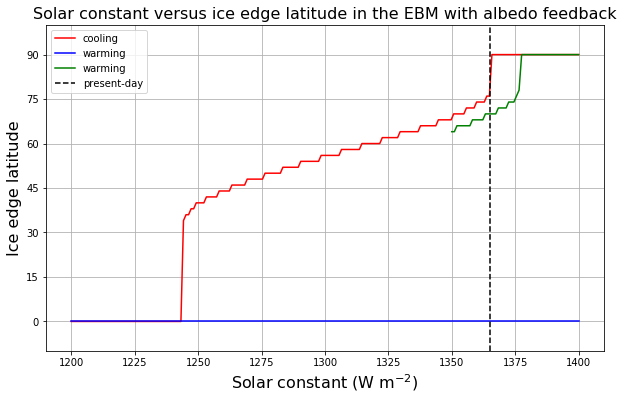

In [19]:
fig = plt.figure( figsize=(10,6) )
ax = fig.add_subplot(111)
ax.plot(S0array, icelat_cooling, 'r-', label='cooling' )
ax.plot(S0array, icelat_warming, 'b-', label='warming' )
ax.plot(S0array3, icelat3, 'g-', label='warming' )
ax.set_ylim(-10,100)
ax.set_yticks((0,15,30,45,60,75,90))
ax.grid()
ax.set_ylabel('Ice edge latitude', fontsize=16)
ax.set_xlabel('Solar constant (W m$^{-2}$)', fontsize=16)
ax.plot( [const.S0, const.S0], [-10, 100], 'k--', label='present-day' )
ax.legend(loc='upper left')
ax.set_title('Solar constant versus ice edge latitude in the EBM with albedo feedback', fontsize=16)
plt.show()

There are actually up to 3 different climates possible for a given value of $S_0$!

### How to un-freeze the Snowball

The graph indicates that if the Earth were completely frozen over, it would be perfectly happy to stay that way even if the sun were brighter and hotter than it is today.

Our EBM predicts that (with present-day parameters) the equilibrium temperature at the equator in the Snowball state is about -33ºC, which is much colder than the threshold temperature $T_f = -10^\circ$C. How can we melt the Snowball?

We need to increase the avaible energy sufficiently to get the equatorial temperatures above this threshold! That is going to require a much larger increase in $S_0$ (could also increase the greenhouse gases, which would have a similar effect)!

Let's crank up the sun to 1830 W m$^{-2}$ (about a 34% increase from present-day).

Integrating for 3600 steps, 14609.688000000002 days, or 40 years.
Total elapsed time is 4044.99999997769 years.


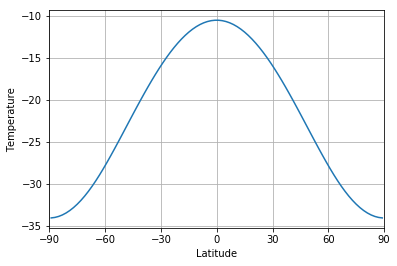

The ice edge is at [-0.  0.]degrees latitude.


In [20]:
model4 = climlab.process_like(model2)  # initialize with cold Snowball temperature
model4.subprocess['insolation'].S0 = 1830.
model4.integrate_years(40)

#lat = model4.domains['Ts'].axes['lat'].points
plt.plot(model4.lat, model4.Ts)
plt.xlim(-90,90)
plt.ylabel('Temperature')
plt.xlabel('Latitude')
plt.grid()
plt.xticks(my_ticks)
plt.show()

print('The ice edge is at ' + str(model4.icelat) + 'degrees latitude.' )

Still a Snowball... but just barely! The temperature at the equator is just below the threshold.

Try to imagine what might happen once it starts to melt. The solar constant is huge, and if it weren't for the highly reflective ice and snow, the climate would be really really hot!

We're going to increase $S_0$ one more time...

Integrating for 900 steps, 3652.4220000000005 days, or 10 years.
Total elapsed time is 4054.999999977441 years.


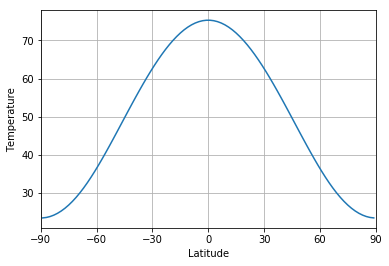

In [21]:
model4.subprocess['insolation'].S0 = 1845.
model4.integrate_years(10)

plt.plot(lat, model4.state['Ts'])
plt.xlim(-90,90)
plt.ylabel('Temperature')
plt.xlabel('Latitude')
plt.grid()
plt.xticks(my_ticks)
plt.show()

Suddenly the climate looks very very different again! The global mean temperature is

In [22]:
print( model4.global_mean_temperature() )

58.171701294999544


A roasty 60ºC, and the poles are above 20ºC. A tiny increase in $S_0$ has led to a very drastic change in the climate.

In [23]:
S0array_snowballmelt = np.linspace(1400., 1900., 50)
icelat_snowballmelt = np.empty_like(S0array_snowballmelt)
icelat_snowballmelt_cooling = np.empty_like(S0array_snowballmelt)

for n in range(S0array_snowballmelt.size):
    model2.subprocess['insolation'].S0 = S0array_snowballmelt[n]
    model2.integrate_years(10, verbose=False)
    icelat_snowballmelt[n] = np.max(model2.diagnostics['icelat'])
    
for n in range(S0array_snowballmelt.size):
    model2.subprocess['insolation'].S0 = np.flipud(S0array_snowballmelt)[n]
    model2.integrate_years(10, verbose=False)
    icelat_snowballmelt_cooling[n] = np.max(model2.diagnostics['icelat'])

Now we will complete the plot of ice edge versus solar constant.

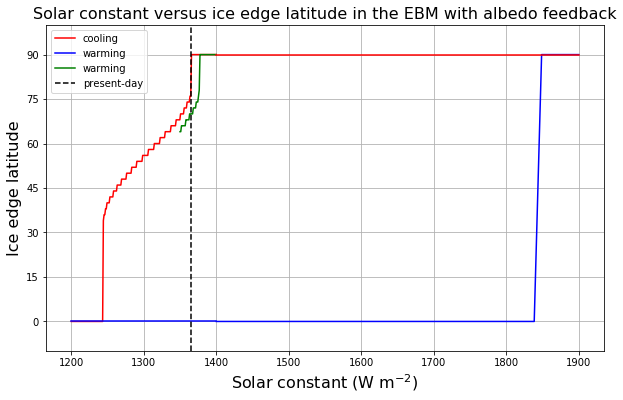

In [24]:
fig = plt.figure( figsize=(10,6) )
ax = fig.add_subplot(111)
ax.plot(S0array, icelat_cooling, 'r-', label='cooling' )
ax.plot(S0array, icelat_warming, 'b-', label='warming' )
ax.plot(S0array3, icelat3, 'g-', label='warming' )
ax.plot(S0array_snowballmelt, icelat_snowballmelt, 'b-' )
ax.plot(S0array_snowballmelt, icelat_snowballmelt_cooling, 'r-' )
ax.set_ylim(-10,100)
ax.set_yticks((0,15,30,45,60,75,90))
ax.grid()
ax.set_ylabel('Ice edge latitude', fontsize=16)
ax.set_xlabel('Solar constant (W m$^{-2}$)', fontsize=16)
ax.plot( [const.S0, const.S0], [-10, 100], 'k--', label='present-day' )
ax.legend(loc='upper left')
ax.set_title('Solar constant versus ice edge latitude in the EBM with albedo feedback', fontsize=16)
plt.show()

The upshot:

- For extremely large $S_0$, the only possible climate is a hot Earth with no ice.
- For extremely small $S_0$, the only possible climate is a cold Earth completely covered in ice.
- For a large range of $S_0$ including the present-day value, more than one climate is possible!
- Once we get into a Snowball Earth state, getting out again is rather difficult!